# Analysis of spinal cord Ucn3 expression in Zeisel et al dataset
Here, we are invesigating the molecular properties of Ucn3 expressing neurons from Zeisel et al (2018) spinal cord dataset [1]. The dataset 'l6_r3_spinal_cord_neurons.loom' was aquired from (http://mousebrain.org/) and contains expressional data from 27,998 genes in 1,922 cells. The dataset was analysed using SCANPY [2] 

The histological findings from our article showed that Ucn3 constitutes an excitatory population, which can further be divided to two subpopulations co-localized with either PKCg or calretinin. The following single-cell mRNA sequencing analysis of the Zeisel et al spinal cord dataset confirmed that Ucn3 is expressed by excitatory neurons, namely SCGLU7 and SCGLU9. Further, Ucn3 expressing SCGLU7 cells co-express Calb2 (encodes calbindin 2) and the SCGLU9 neurons express Prkcg (encodes PKCg), thus, this transcriptional analysis confirms the histological findings.



References;


[1] Zeisel, A., Hochgerner, H., Lönnerberg, P. et al. (2018). Molecular Architecture of the Mouse Nervous System. Cell, doi: 10.1016/j.cell.2018.06.021

[2] Wolf, F.A.,Angerer, P., Theis, F.J. 2018. SCANPY: large-scale single-cell gene expression data analysis. 

[3] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. JMLR, 12(85):2825−2830, 2011

[4] Satija, R., Farrell, J.A., Gennert, D., Schier A.F., Regev, A. (2015). Spatial reconstruction of single-cell gene expression data. Nature Biotechnology 33:495–502 

[5] Zheng, G.X.Y., Terry, J.M., …Bielas, J.H. (2017). Massively parallel digital transcriptional profiling of single cells. Nature Communications volume 8, Article number: 14049

[6] Stuart, T., Butler, A., Hoffman, P., Hafemeister, C., Papalexi, E., Mauckm M.M., Hao, Y., Stoeckius, M., Smibert, P., Satija, P. (2019). Comprehensive Integration of Single-Cell Data. Cell, doi: 10.1016/j.cell.2019.05.031

[7] McInnes, L., Healy, J., Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv:1802.03426 




In [1]:
# import necessary modules for analysis
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import loompy

# make the text in figures editable in Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-10-26 08:30.


The following functions were used in the analysis

In [3]:
"""function for calculating the percentage of cells expressing gene of interest"""
def percentage_exp(adata, genes):
    per_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.5])/len(adata.X) # calculate the percentage of cells expressing gene(s) of interest
        per_list.append((gene, percentage*100)) # add the name of gene and the percentage to list
    return sorted(per_list, key=lambda tup: tup[1], reverse = True) #rank the level of prevalence in list

"""function for calculating the number of cells expressing gene of interest"""
def number_exp(adata, genes):
    num_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.25])/len(adata.X)# calculate the percentage of cells expressing gene(s) of interest
        num_list.append((gene, percentage*len(adata.X))) # add the name of gene and the number of cells expressing gene of intererest
    return sorted(num_list, key=lambda tup: tup[1], reverse = True) #rank the level of prevalence in list

"""function for calculating the number of cells belonging to specific categorical observation"""
def calc_celltype_observation(adata, observation):
    pd_adata = pd.DataFrame(index = adata.obs_names, columns = adata.var_names, data = adata.X) #convert AnnData object to a dataframe. 
    # does not work to make calculations directly onthe AnnData object
    pd_adata['obs_name'] = adata.obs[observation] #create new column in dataframe depending on the target observation in the AnnData object
    pd_celltype = pd.DataFrame(pd_adata.loc[pd_adata.index, 'obs_name']) # extract the index and the target observation
    pd_celltype = pd.DataFrame(pd_adata.groupby('obs_name').size(), columns = ['number_cells']) #calculate the number of cells belonging to each 
    return(pd_celltype)                                                                         ## category of the target observation

In [4]:
# open the Zeisel et al dataset
adata = sc.read_loom('l6_r3_spinal_cord_neurons.loom', sparse = False)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1922 × 27998
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Clas

Isolate the true neurons from the Zeisel dataset to be used for basic preprocessing and analysis

In [5]:
# isolate the true neurons from Zeisel et al dataset. 
# already saved as observation from raw dataset
sc_neurons = [name for name in adata.obs['ClusterName'] if name.startswith('SC')]
adata.obs['true_sc'] = adata.obs['ClusterName'].isin(sc_neurons).astype(str)
adata = adata[adata.obs['true_sc'] == 'True']
adata

View of AnnData object with n_obs × n_vars = 1744 × 27998
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular

In [6]:
# filter out cells expressing less than 200 different genes and genes found in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

# make variables and observations unique
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 13356 genes that are detected in less than 3 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1744 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Clas

Identify ERCC sequences and mitochondrial genes to calculate the metrics for basic preprocessing

In [7]:
# no ERCC genes identified, do not use to calulate metrics
print([name for name in adata.var_names if name.startswith('ERCC')])
print([name for name in adata.var_names if name.startswith('ercc')])

[]
[]


... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as categorical
... storing 'Mean Reads per Cell' as categorical
... storing 'Median Genes per Cell' as categorical
... storing 'Median UMI Counts per

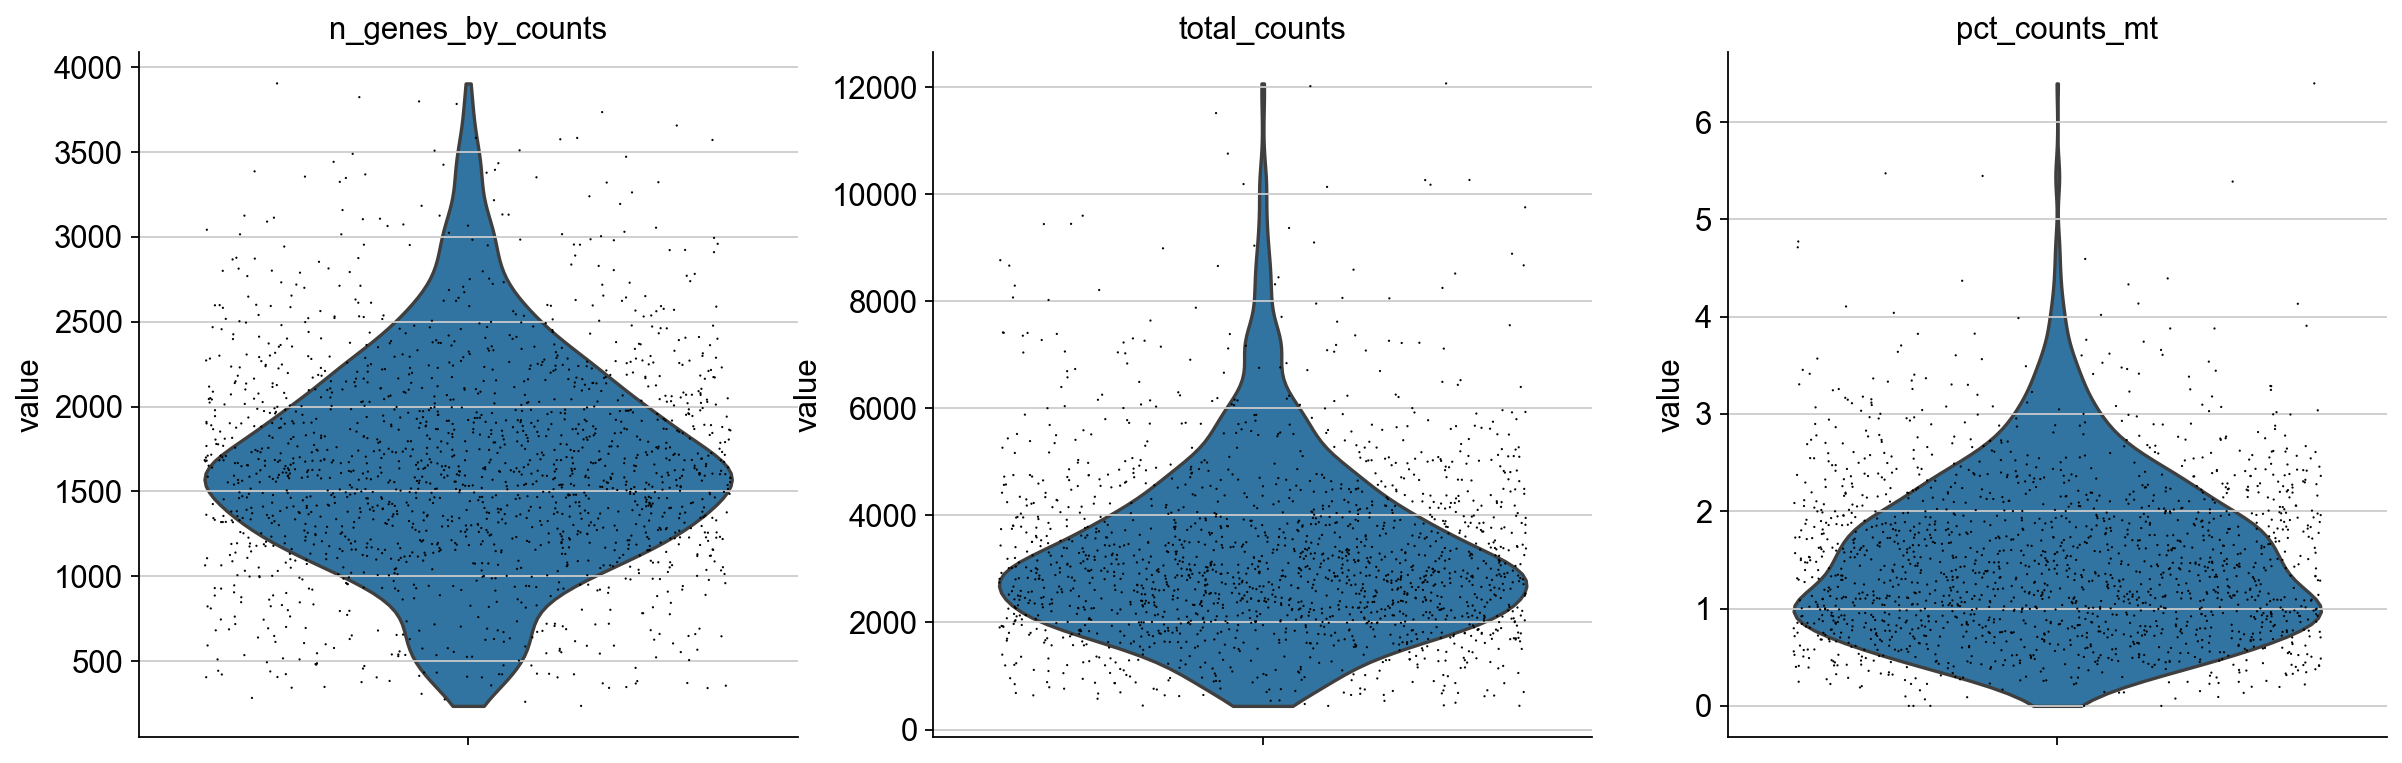

AnnData object with n_obs × n_vars = 1744 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Clas

In [8]:
# add the total counts per cell as observation
adata.obs['n_counts'] = np.sum(adata.X, axis=1)

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('mt-')  
# calulate the metrics of mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

#plot the mitochondrial data
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# make variables and observations unique
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log1p_total_counts', ylabel='Density'>

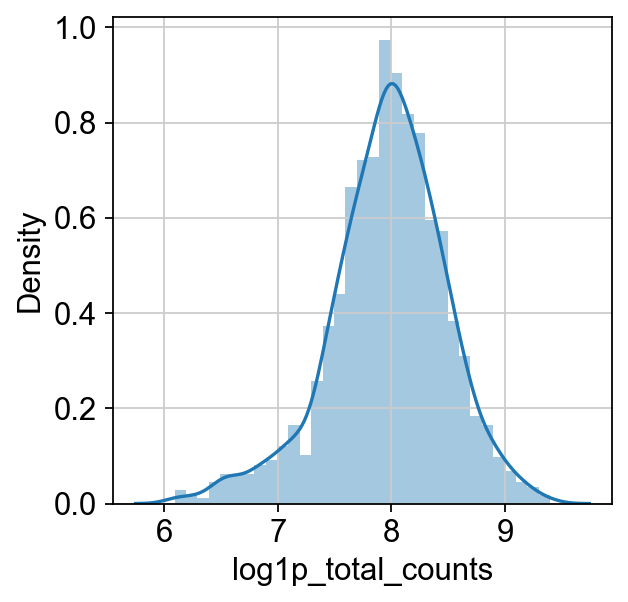

In [9]:
sns.distplot(adata.obs['log1p_total_counts'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


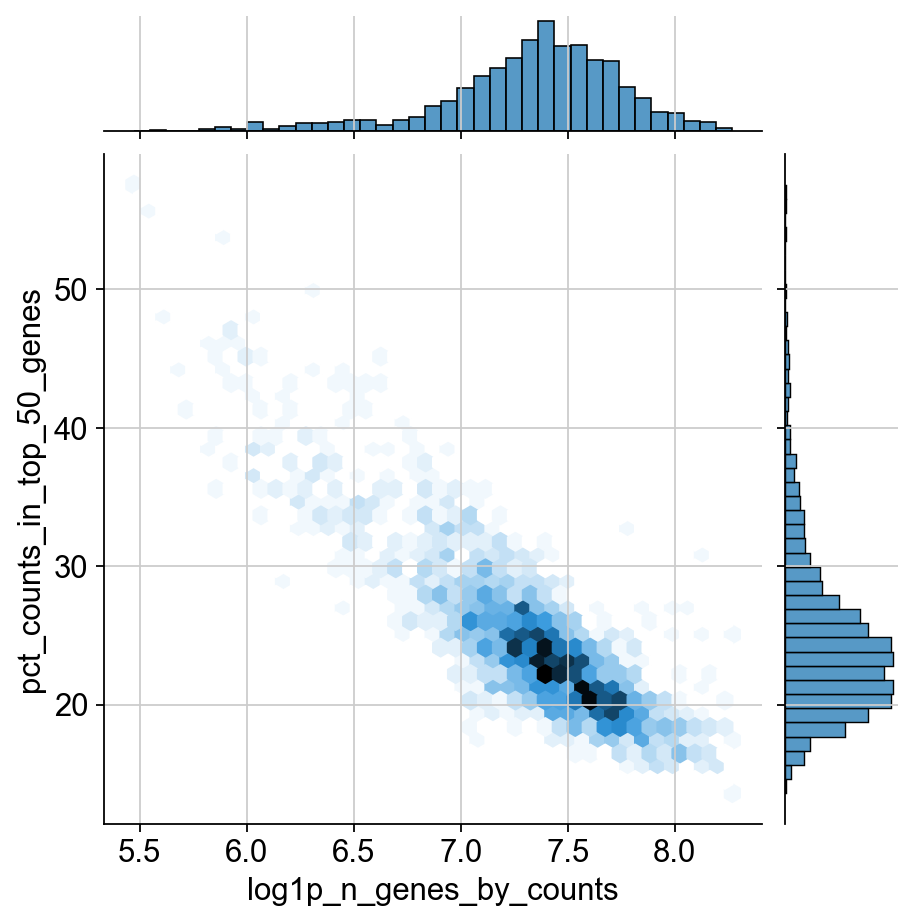

In [10]:
# plot the logaritmized number of genes by counts and the percentage of counts that express the top 50 most expressed genes
sns.jointplot('log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', data=adata.obs, kind="hex")

In [11]:
# do the actual filtering to exclude cells 
adata = adata[adata.obs.pct_counts_mt < 4, :] # include cells with low mithochondrial expression
adata = adata[adata.obs.log1p_total_counts > 6.5, :]
adata = adata[adata.obs.pct_counts_in_top_50_genes < 50, :] # filter cells with distributed gene counts
adata = adata[adata.obs.log1p_n_genes_by_counts > 6.0, :] # filter cells with broad gene capture

In [12]:
# normalize the number of reads per cell to the median number of reads
sc.pp.normalize_per_cell(adata, counts_per_cell_after= adata.obs['n_counts'].median())

# logaritmize data
sc.pp.log1p(adata)

adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 1707 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Clas

## Ucn3 expression analysis

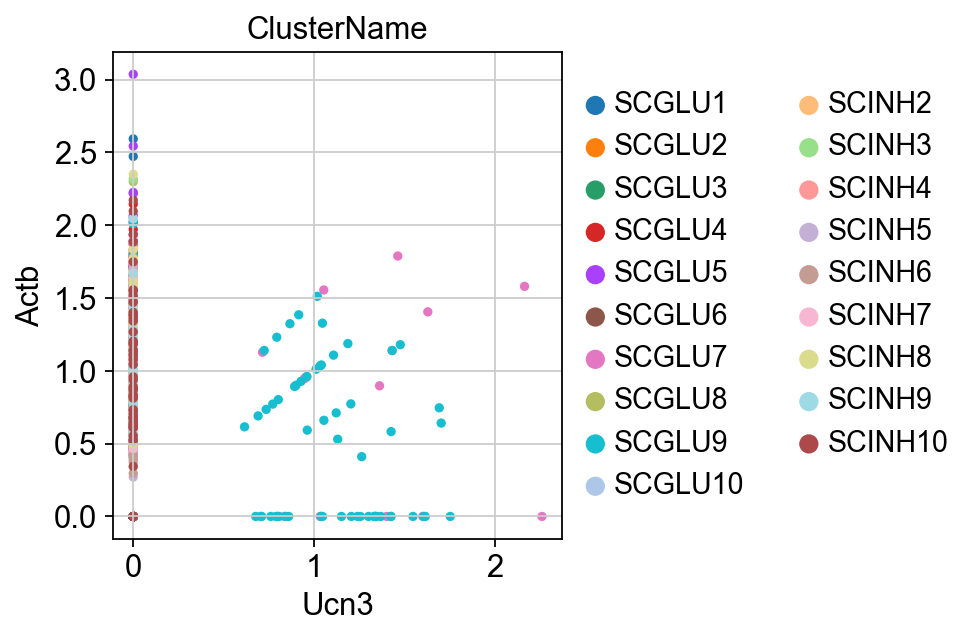

In [13]:
# investigate the expression level of Ucn3
sc.pl.scatter(adata, x = 'Ucn3', y = 'Actb', color = 'ClusterName', save = 'scatter_log_ucn3_housegene')

Scatterplot used to set threshold for cells considering expressing Ucn3. Neuron now considered to express the targeted gene if log1p > 0.5. Scatterplot also shows that Ucn3 expression is found in SCGLU7 and SCGLU9

In [14]:
# save observation for cell considered expressing Ucn3
adata.obs['ucn3_cell'] = (adata[:, 'Ucn3'].X > 0.5).astype(str)


#make observation for inhibitory and excitatory neurons to be used for further analysis
excit_celltype = [name for name in adata.obs['ClusterName'] if name.startswith('SCG')]
adata.obs['excit_celltype'] = adata.obs['ClusterName'].isin(excit_celltype).astype(str)

... storing 'ucn3_cell' as categorical
... storing 'excit_celltype' as categorical


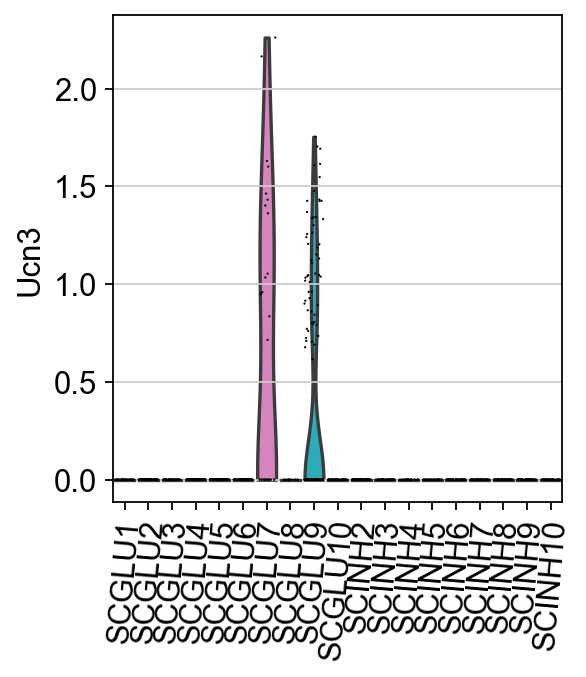

In [15]:
sc.pl.violin(adata, 'Ucn3', use_raw= False, stripplot = True, jitter = 0.4, groupby = 'ClusterName', rotation= 85, save = 'ucn3_exp_clusernames.pdf')

Violinplot confirming that Ucn3 is only expressed in excitatory SCGLU7 and SCGLU9. 

To detect the homologousness of excitatory neurons, the excitatory spinal cord neurons are isolated 

In [16]:
# calculate the prevalence of Ucn3 expression in all the Zeisel et al spinal cord cells
percentage_exp(adata, ['Ucn3', 'Actb'])

[('Actb', 67.7211482132396), ('Ucn3', 4.2765084944346805)]

In [17]:
print('the number of inhibitory neurons in dataset is ',np.sum(adata.obs['excit_celltype'] != 'True'))
print('the number of excitatory neurons in dataset is ',np.sum(adata.obs['excit_celltype'] == 'True'))

the number of inhibitory neurons in dataset is  647
the number of excitatory neurons in dataset is  1060


In [18]:
adata_glu = adata[adata.obs['excit_celltype'] == 'True']
adata_glu

View of AnnData object with n_obs × n_vars = 1060 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular

### Clustering and Vizualisation of excitatory spinal cord Zeisel et al neurons

From previous graphs, it is visualized that Ucn3 is specifically expressed by neurons belonging to the SCGLU7 and SCGLU9 neurons, and further, that the targeted gene is not present in inhibitory neurons, Therefore, for the subsequent analysis, we wanted to investigate the similarities of the excitatory neurons and more specifically, if the SCGLU7 and SCGLU9 share expressional similarities. 

Here we use PCA for dimension reduction (Pedrigosa et al (2011), [3]), calculated from the top higly expressed genes (Satija et al. (2015), [4]; Zheng et al. (2017), [5]; Stuart et al. (2019), [6]) and further, Uniform Manifold Approximation and Projection (UMAP) to compute distances and connectivities, as well as for visualization (McInnes et al (2018), [7]). 

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


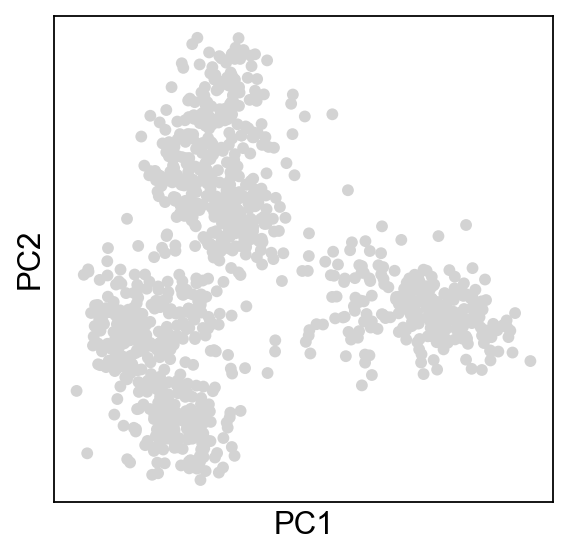

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


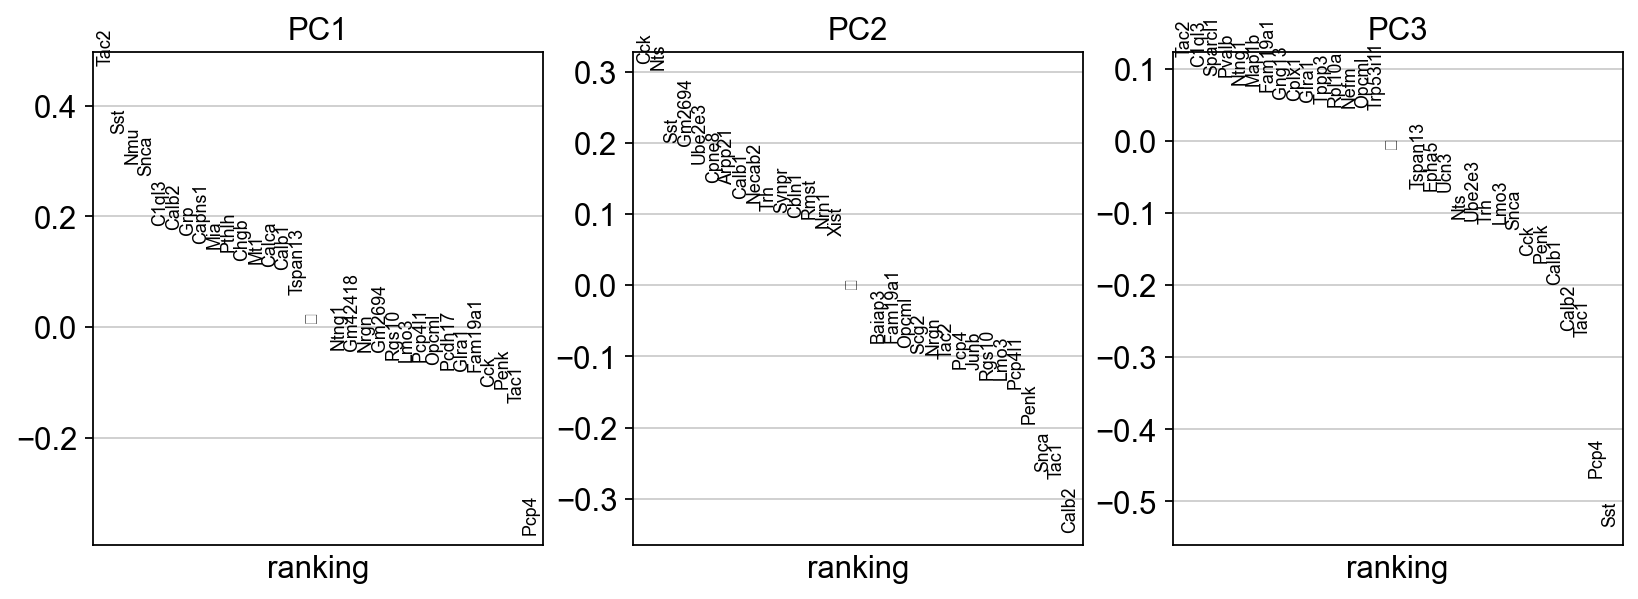

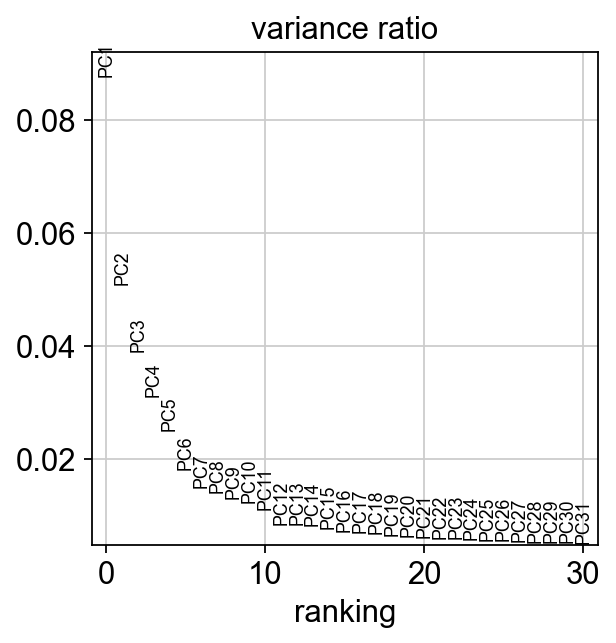

In [19]:
# detect the most highest variable genes
sc.pp.highly_variable_genes(adata_glu, n_top_genes=1000, inplace=True)

# reduce dimensions of data using the highest variable genes
sc.pp.pca(adata_glu, use_highly_variable=True)
sc.pl.pca_overview(adata_glu)

The closer proximity of cells and clusters indicate expressional similarity- here we see that the clusters expressing Ucn3; SCGLU7 and SCGLU9 are close. Further, displaying the expression of Ucn3 also confirms expressional homologousity of Ucn3 expressing cells

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


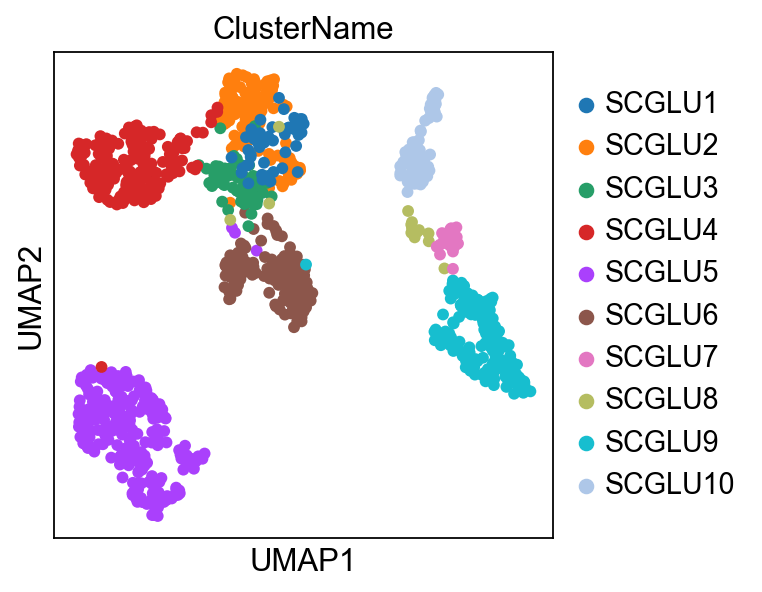

In [20]:
# compute neighborhood graph and visualize with UMAP
sc.pp.neighbors(adata_glu, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_glu)
sc.pl.umap(adata_glu, color = 'ClusterName')

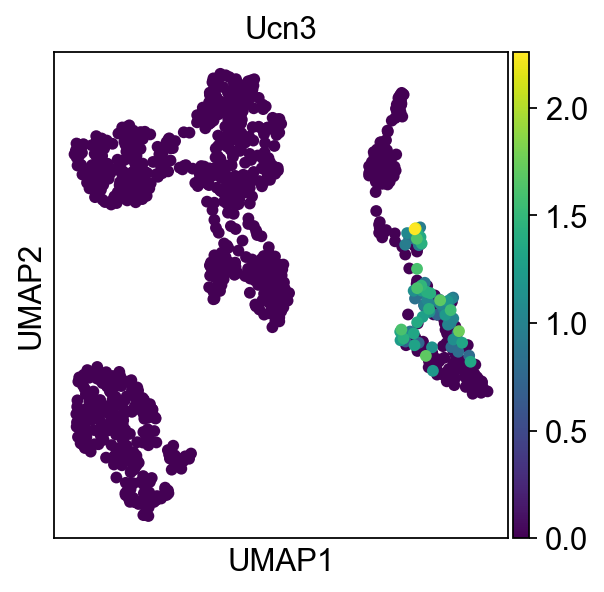

In [21]:
sc.pl.umap(adata_glu, color = 'Ucn3', save = 'Ucn3_expression_SCGLU.pdf')

## Compute the expressional difference between the Ucn3 expressing subclusters

Isolation of Ucn3 cells to detect differences in the SCGLU7 and SCGLU9 neurons co-expressing Ucn3

In [22]:
adata_ucn3 = adata_glu[adata_glu.obs['ucn3_cell'] == 'True']
adata_ucn3

View of AnnData object with n_obs × n_vars = 73 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular',

calculate how many cells in each subcluster that express Ucn3

In [23]:
calc_celltype_observation(adata_ucn3, 'ClusterName')

,number_cells
obs_name,
SCGLU7,15
SCGLU9,58


In [24]:
sc.tl.rank_genes_groups(adata_ucn3, groupby= 'ClusterName', use_raw = False)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


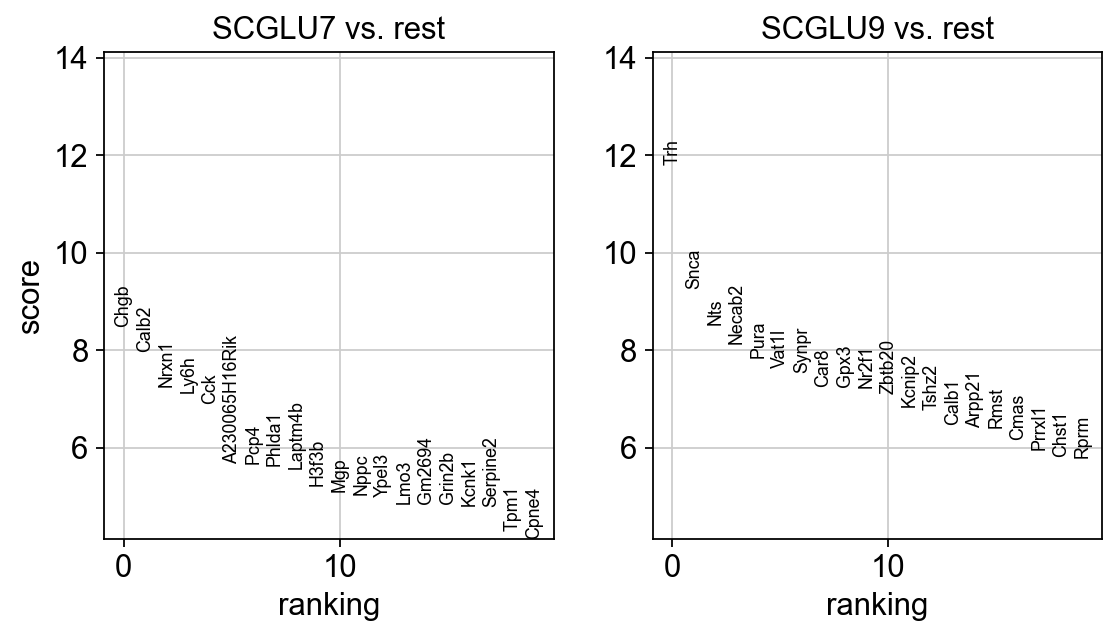

In [25]:
sc.pl.rank_genes_groups(adata_ucn3)

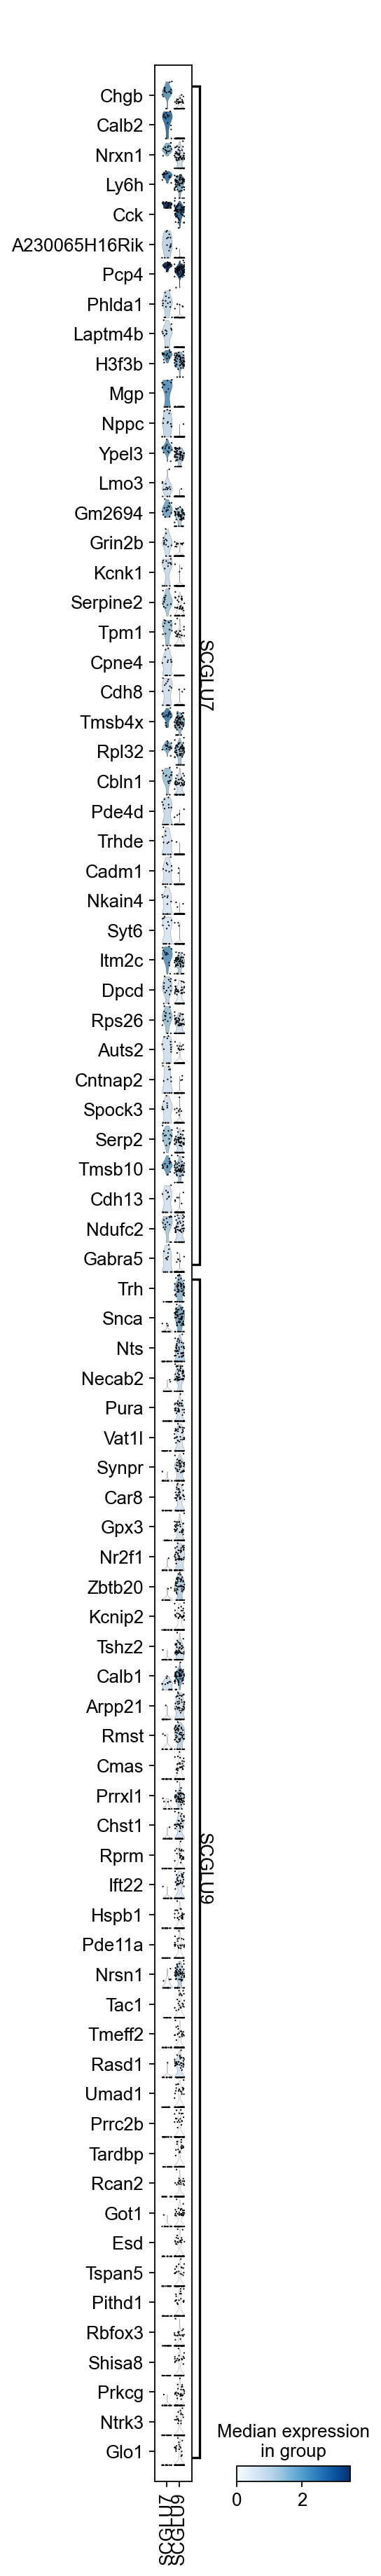

In [47]:
sc.pl.rank_genes_groups_stacked_violin(adata_ucn3, use_raw= False, stripplot = True, col_palette = ['#e377c2', '#17becf'], jitter = 0.4, groupby= 'ClusterName',
                                       n_genes = 40, swap_axes= True, save='violin_rank_genes_glu_ucn3.pdf')

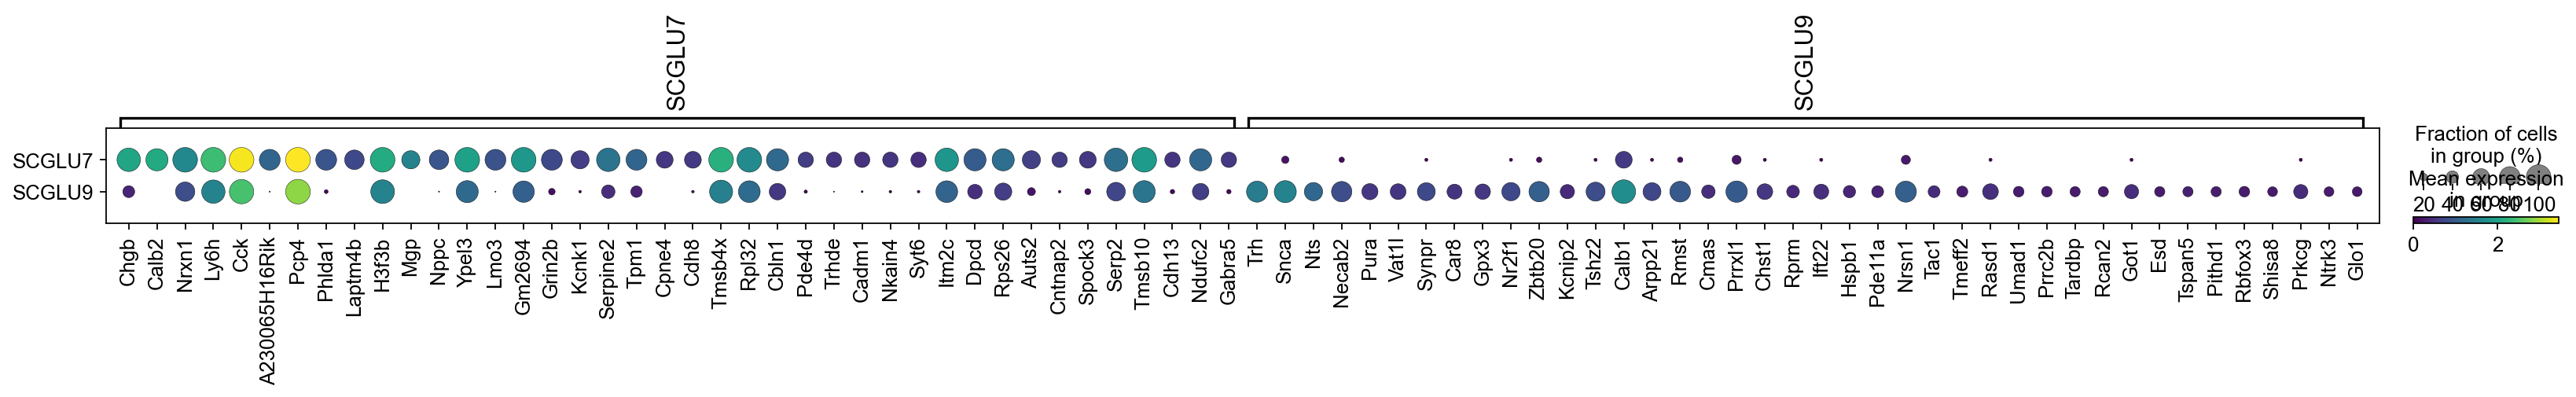

In [62]:
sc.pl.rank_genes_groups_dotplot(adata_ucn3, figsize = (25,1), use_raw= False, groupby= 'ClusterName',
                                cmap = 'viridis', n_genes = 40, save= 'dotplot_FDR_expression.pdf')

In [29]:
result = adata_ucn3.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(40)

,SCGLU7_n,SCGLU7_s,SCGLU7_p,SCGLU9_n,SCGLU9_s,SCGLU9_p
0,Chgb,8.484240,0.000127,Trh,11.809421,8.772401e-13
1,Calb2,7.972760,0.000745,Snca,9.263177,5.474840e-09
2,Nrxn1,7.249421,0.000004,Nts,8.512845,4.750313e-08
3,Ly6h,7.118966,0.000007,Necab2,8.123400,2.641494e-07
4,Cck,6.893697,0.000006,Pura,7.846682,3.165208e-07
5,A230065H16Rik,5.661798,0.013381,Vat1l,7.633348,5.855185e-07
6,Pcp4,5.659884,0.000829,Synpr,7.538999,3.165208e-07
7,Phlda1,5.626710,0.011919,Car8,7.248075,1.813215e-06
8,Laptm4b,5.555880,0.014811,Gpx3,7.245893,1.813215e-06
9,H3f3b,5.218575,0.002695,Nr2f1,7.236891,1.236333e-06


Calculation of the prevalence of Ucn3 expression in each each spinal cord cluster

In [32]:
df_ucn3 = calc_celltype_observation(adata_ucn3, 'ClusterName')
df_all = calc_celltype_observation(adata, 'ClusterName')

print(df_ucn3)
print(df_all)

# print the percentage of neurons from each cluster expressing Glra3
print(df_ucn3.div(df_all)*100)

          number_cells
obs_name              
SCGLU7              15
SCGLU9              58
          number_cells
obs_name              
SCGLU1              50
SCGLU2             128
SCGLU3              62
SCGLU4             174
SCGLU5             250
SCGLU6             133
SCGLU7              28
SCGLU8              15
SCGLU9             152
SCGLU10             68
SCINH2             115
SCINH3              64
SCINH4              36
SCINH5              44
SCINH6              86
SCINH7              71
SCINH8              87
SCINH9              79
SCINH10             65
          number_cells
obs_name              
SCGLU1             NaN
SCGLU10            NaN
SCGLU2             NaN
SCGLU3             NaN
SCGLU4             NaN
SCGLU5             NaN
SCGLU6             NaN
SCGLU7       53.571429
SCGLU8             NaN
SCGLU9       38.157895
SCINH10            NaN
SCINH2             NaN
SCINH3             NaN
SCINH4             NaN
SCINH5             NaN
SCINH6             NaN
SCINH7     

calculation of prevalnce of the targeted genes in all spinal cord neurons

In [33]:
print(pd.DataFrame(percentage_exp(adata_ucn3, ['Prkcg', 'Calb2', 'Tac2'])))

       0          1
0  Prkcg  36.986301
1  Calb2  17.808219
2   Tac2   0.000000


In [34]:
#isolation of Ucn3 expressing SCGLU7 cells
adata_ucn3_glu7 = adata_ucn3[adata_ucn3.obs['ClusterName'] == 'SCGLU7']
adata_ucn3_glu7

View of AnnData object with n_obs × n_vars = 15 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular',

In [35]:
# detecting the expression of targeted genes on Ucn3 expressing SCGLU7 neurons
print(pd.DataFrame(percentage_exp(adata_ucn3_glu7, ['Prkcg', 'Calb2'])))

       0          1
0  Calb2  86.666667
1  Prkcg   6.666667


In [36]:
# isolation of Ucn3 expressing SCGLU9 neurons
adata_ucn3_glu9 = adata_ucn3[adata_ucn3.obs['ClusterName'] == 'SCGLU9']
adata_ucn3_glu9

View of AnnData object with n_obs × n_vars = 58 × 14642
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular',

In [37]:
# calculation of targeted genes in the Ucn3 expressing SCGLU9 neurons
print(pd.DataFrame(percentage_exp(adata_ucn3_glu9, ['Prkcg', 'Calb2'])))

       0          1
0  Prkcg  44.827586
1  Calb2   0.000000
